In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

Train shape: (1961, 982)

Data Types: 
 date_id           int64
LME_AH_Close    float64
LME_CA_Close    float64
LME_PB_Close    float64
LME_ZS_Close    float64
                 ...   
target_419      float64
target_420      float64
target_421      float64
target_422      float64
target_423      float64
Length: 982, dtype: object

Head:
    date_id  LME_AH_Close  LME_CA_Close  LME_PB_Close  LME_ZS_Close  \
0        0        2264.5        7205.0        2570.0        3349.0   
1        1        2228.0        7147.0        2579.0        3327.0   
2        2        2250.0        7188.5        2587.0        3362.0   
3        3        2202.5        7121.0        2540.0        3354.0   
4        4        2175.0        7125.0        2604.0        3386.0   

   JPX_Gold_Mini_Futures_Open  JPX_Gold_Rolling-Spot_Futures_Open  \
0                         NaN                                 NaN   
1                         NaN                                 NaN   
2                      4684.0    

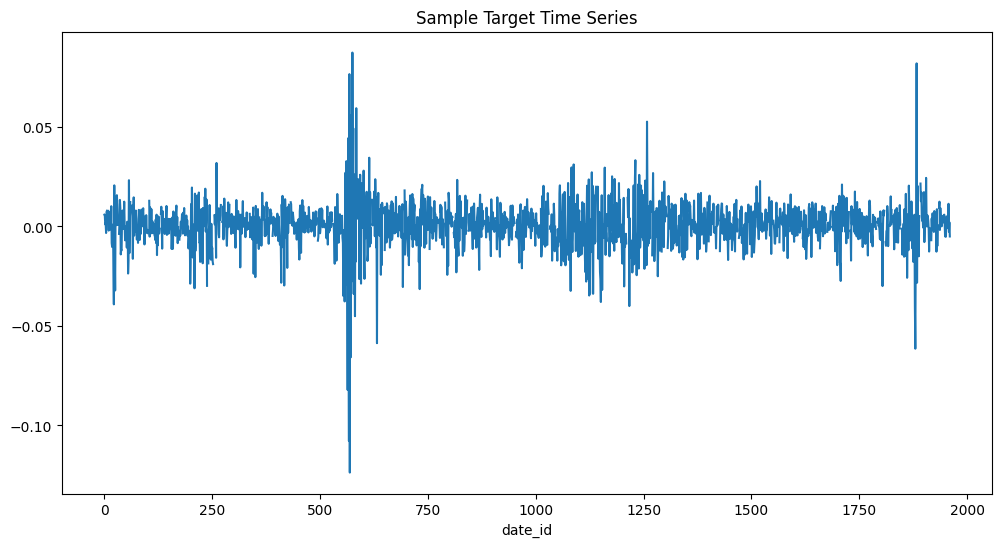

ADF: -13.390344192682306, p value: 4.781304109930056e-25

 Top correlations with target: 
 target_0      1.000000
target_8      0.710729
target_35     0.690702
target_106    0.627345
target_52     0.597600
target_17     0.576008
target_100    0.571271
target_46     0.560303
target_58     0.555706
target_66     0.555678
Name: target_0, dtype: float64

 Percentage missing: 
 US_Stock_GOLD_adj_high      87.353391
US_Stock_GOLD_adj_low       87.353391
US_Stock_GOLD_adj_open      87.353391
US_Stock_GOLD_adj_close     87.353391
US_Stock_GOLD_adj_volume    87.353391
target_404                  18.867925
target_82                   18.306986
target_235                  17.848037
target_276                  17.848037
target_288                  17.848037
dtype: float64

Target Pairs head (defines targets):
      target  lag                                            pair
0  target_0    1                           US_Stock_VT_adj_close
1  target_1    1            LME_PB_Close - US_Stock_VT_adj_c

In [2]:
#SETUP + EDA BASELINE

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_labels = pd.read_csv('train_labels.csv')
#lagged_test_labels = pd.read_csv('lagged_test_labels.csv')
target_pairs = pd.read_csv('target_pairs.csv')

train = train.merge(train_labels, on='date_id', how = 'left')

print("Train shape:", train.shape)
print("\nData Types: \n", train.dtypes)
print("\nHead:\n", train.head())
print("\nMissing Values:\n", train.isnull().sum())

#Parse date
train.set_index('date_id', inplace = True)

target_cols = [col for col in train.columns if 'target' in col]  # Captures target 0 to target 423
print("\nNumber of targets:", len(target_cols))

if 'target' in train.columns:
    train['target'].plot(figsize=(12, 6))
else:
    target_cols = [col for col in train.columns if 'return' in col or 'target' in col]
    train[target_cols[0]].plot(figsize=(12, 6))
plt.title('Sample Target Time Series')
plt.show()

#ADF test
if 'target' in train.columns:
    adf_result = adfuller(train['target'].dropna())
else:
    adf_result = adfuller(train[target_cols[0]].dropna())

print(f'ADF: {adf_result[0]}, p value: {adf_result[1]}')

if 'target' in train.columns:
    corr = train.corr()['target'].sort_values(ascending=False)
else:
    corr = train.corr()[target_cols[0]].sort_values(ascending = False)
print("\n Top correlations with target: \n", corr.head(10))

print("\n Percentage missing: \n", (train.isnull().mean() * 100).sort_values(ascending = False).head(10))

print("\nTarget Pairs head (defines targets):\n", target_pairs.head())

In [3]:
#HANDLE MISSING VALUES + PREPROCESSING

from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

train = train.ffill().bfill() #forward and backward fill for NaNs + time continuity

high_missing = (train.isnull().mean() > 0.5).index[train.isnull().mean() > 0.5]
train = train.drop(columns = high_missing)

train = train.fillna(train.mean())

target_cols = [col for col in train.columns if 'target' in col]


lag_dfs = []
roll_dfs = []
for lag in [1, 2, 3, 7, 14, 30]:
    lag_df = train[target_cols + ['LME_CA_Close', 'LME_PB_Close']].shift(lag).add_suffix(f'_lag_{lag}')
    lag_dfs.append(lag_df)

for window in [7, 30]:
    roll_mean = train[target_cols].rolling(window).mean().add_suffix(f'_roll_mean_{window}')
    roll_std = train[target_cols].rolling(window).std().add_suffix(f'_roll_std_{window}')
    roll_dfs.append(pd.concat([roll_mean, roll_std], axis=1))


new_features = pd.concat(lag_dfs + roll_dfs, axis=1)


train = pd.concat([train, new_features], axis=1)

# time features
train['dayofweek'] = train.index % 7
train['week'] = train.index // 7
train['sin_week'] = np.sin(2 * np.pi * train['week'] / 52)  # Fourier for cycles


train = train.dropna()

# Feature cols
feature_cols = [col for col in train.columns if col not in target_cols]

# Scale
scaler = StandardScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index=train.index)

print("Preprocessed shape:", train_scaled.shape)
print("\nSample new features:", new_features.columns[:10])  # First 10 added


Preprocessed shape: (1931, 5236)

Sample new features: Index(['target_0_lag_1', 'target_1_lag_1', 'target_2_lag_1', 'target_3_lag_1',
       'target_4_lag_1', 'target_5_lag_1', 'target_6_lag_1', 'target_7_lag_1',
       'target_8_lag_1', 'target_9_lag_1'],
      dtype='object')


In [15]:
#baseline LSTM

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# sequences for univariate baseline
def create_sequences(data, seq_length, target_col=target_cols[0]):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)][target_col].values
        y = data.iloc[i + seq_length][target_col]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60
X, y = create_sequences(train_scaled, seq_length)
X = X[..., np.newaxis]  # (samples, seq, 1) for univariate


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()

# Dataset/Loader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.linear(out[:, -1, :])

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train loop
epochs = 50
for epoch in range(epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}')

# Val eval
model.eval()
with torch.no_grad():
    val_pred = model(X_val).squeeze().numpy()
val_loss = criterion(torch.from_numpy(val_pred), y_val).item()
print(f'Val MSE: {val_loss:.4f}')

Epoch 0, Train Loss: 0.3245
Epoch 10, Train Loss: 0.3258
Epoch 20, Train Loss: 0.3350
Epoch 30, Train Loss: 0.3391
Epoch 40, Train Loss: 0.3433
Val MSE: 0.8808
